**What Is Optical Coherence Tomography?**


Optical coherence tomography (OCT) is a non-invasive imaging test. OCT uses light waves to take cross-section pictures of your retina.

With OCT, your ophthalmologist can see each of the retina’s distinctive layers.  This allows your ophthalmologist to map and measure their thickness. These measurements help with diagnosis. They also provide treatment guidance for glaucoma and diseases of the retina. These retinal diseases include age-related macular degeneration (AMD) and diabetic eye disease.


![RETINAL OCT OF A NORMAL EYE](https://www.aao.org/image.axd?id=0acdb964-d6ca-4034-ab9c-a731c5f5edf2&t=635072561627800000)
@IMAGE COURTESYhttps://www.aao.org 



OCT is useful in diagnosing many eye conditions, including:

* macular hole
* macular pucker
* macular edema
* age-related macular degeneration
* glaucoma
* central serous retinopathy
* diabetic retinopathy
* vitreous traction


**ABOUT OUR DATA SET**

* The dataset is organized into 3 folders **(train, test, val)**. It contains subfolders for each image category **(NORMAL,CNV,DME,DRUSEN)**. There are 84,495 X-Ray images (JPEG) and 4 categories (NORMAL,CNV,DME,DRUSEN). 

* Images are labeled as (disease)-(randomized patient ID)-(image number by this patient) and split into 4 directories: CNV, DME, DRUSEN, and NORMAL.
 

**WHAT ALL TO EXPECT FROM THIS KERNEL**

1. Feature map visualization and filter visualization.

2. Modular code so that functions in this kernel can be used easily by everyone,all you need to do is define the model and pass it through function call to convert_data function as demonstrated in last line by convert_data(model). 

3. You can easily increase accuracy by adjusting hyper-parameters, for demonstration purposes,due to memory constraints and since I just wanted to show feature map visualization and filter visualization while maintaining modularity of code.

4. Scalable approach thus you can easily put in any adaptive learning model or a bigger CNN too and pass the model to convert_data function. It will detect all convolutional layers and plot 32 feature maps of each convolutional layer in model.  


**HOW WILL VISUALIZATION OF FEATURES AND FILTERS HELP**

1. What I find best part about feature visualization is that it kind of tells us how our eye detects feature. If suppose we have an object we analyze many features of that object like its shape,colour,size etc, when we see an object say in a photograph our eye tries to find patterns in the photograph that is peculiar to something it has seen before.These patterns thus play a vital role in discerning the object we detect.What more images in these dataset is of an eye itself (talk about inception :P).

2. Large Convolutional Network models have recently demonstrated impressive classification performance on the ImageNet benchmark. However there is no clear understanding of why they perform so well, or how they might be improved. Thus visualization can help to gain an insight to what our model has learnt.

3. The patterns so detected can be study to adjust hyperparameters and filters in a way to get more accuracy.

**I would be grateful to anyone who can help me improve my code I am still learning. Any suggestions are appreciated. I tried to maintain modularity while coding for easy understanding. Thank you.**

**So let's get started with this kernel**


In [1]:
# import numpy as np # linear algebra
# import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
# import os
# print(os.listdir("../Downloads/kermany2018/OCT2017_/val"))
# # Any results you write to the current directory are saved as output.

In [1]:
TRAIN_PATH='../Downloads/kermany2018/OCT2017_/train'
TEST_PATH='../Downloads/kermany2018/OCT2017_/test'
VAL_PATH='../Downloads/kermany2018/OCT2017_/val'

In [2]:
import os
import gc
import re
import operator 
import numpy as np
import pandas as pd
from gensim.models import KeyedVectors
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

In [3]:
import tensorflow as tf
from wordcloud import WordCloud
from collections import Counter
from nltk.corpus import stopwords
from nltk.util import ngrams

In [4]:
import matplotlib.image as mpimg
import imageio as im
from tensorflow.keras import models
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import MaxPooling2D
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Dropout
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ModelCheckpoint

###### Let's take a look at the first 25 images in each of the classes within the test forlder.

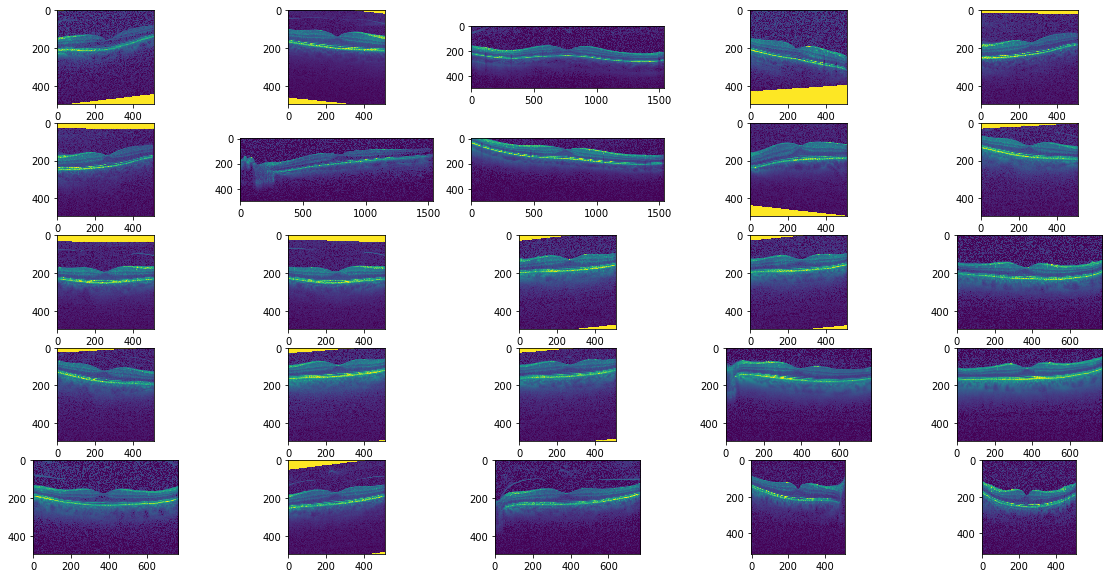

In [5]:
import glob
imagesTrainNORMAL = []
for img_path in glob.glob('../Downloads/kermany2018/OCT2017_/train/NORMAL/*.jpeg'):
    imagesTrainNORMAL.append(mpimg.imread(img_path))
plt.figure(figsize=(20,10))
columns = 5
for i in range(0, 25):
    plt.subplot(5, 5, i + 1)
    plt.imshow(imagesTrainNORMAL[i])

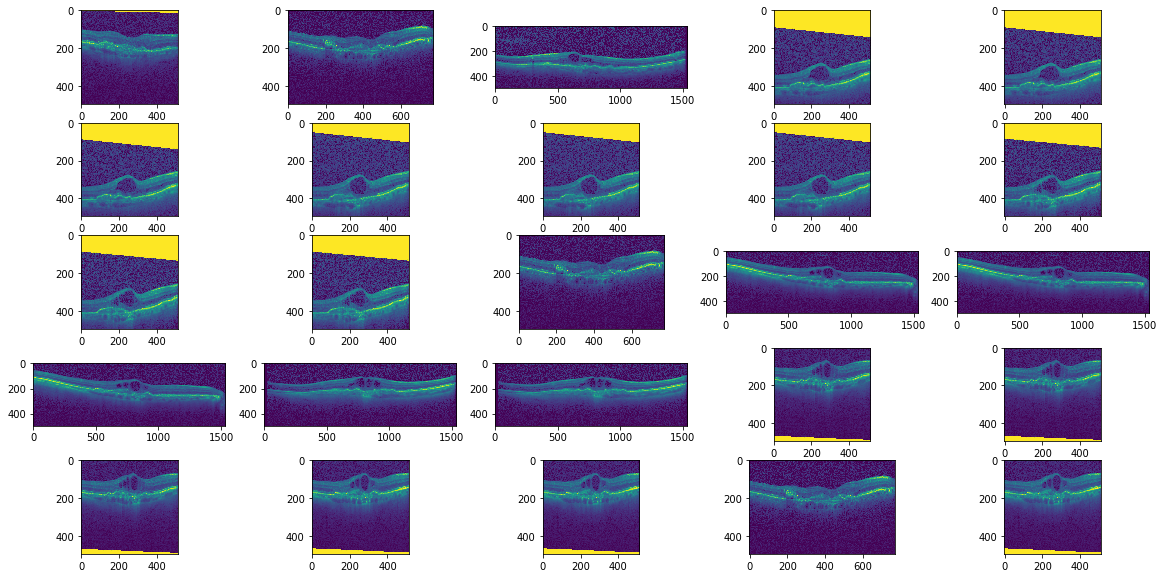

In [7]:
imagesTrainCNV = []
for img_path in glob.glob('../Downloads/kermany2018/OCT2017_/train/CNV/*.jpeg'):
    imagesTrainCNV.append(mpimg.imread(img_path))
plt.figure(figsize=(20,10))
for i in range(0, 25):
    plt.subplot(5, 5, i + 1)
    plt.imshow(imagesTrainCNV[i])

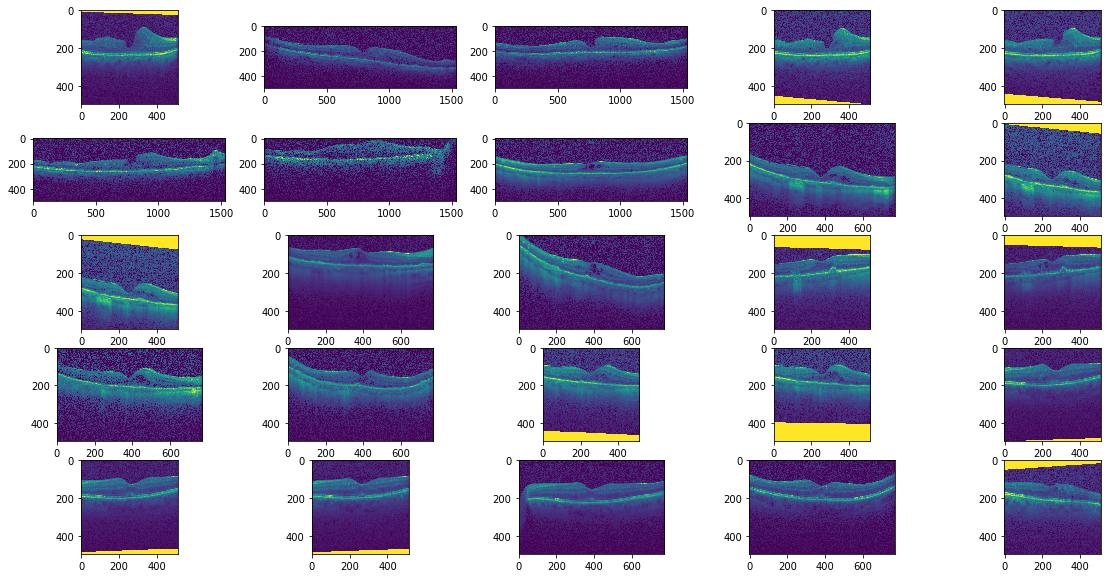

In [6]:
imagesTrainDME = []
for img_path in glob.glob('../Downloads/kermany2018/OCT2017_/train/DME/*.jpeg'):
    imagesTrainDME.append(mpimg.imread(img_path))
plt.figure(figsize=(20,10))
for i in range(0, 25):
    plt.subplot(5, 5, i + 1)
    plt.imshow(imagesTrainDME[i])

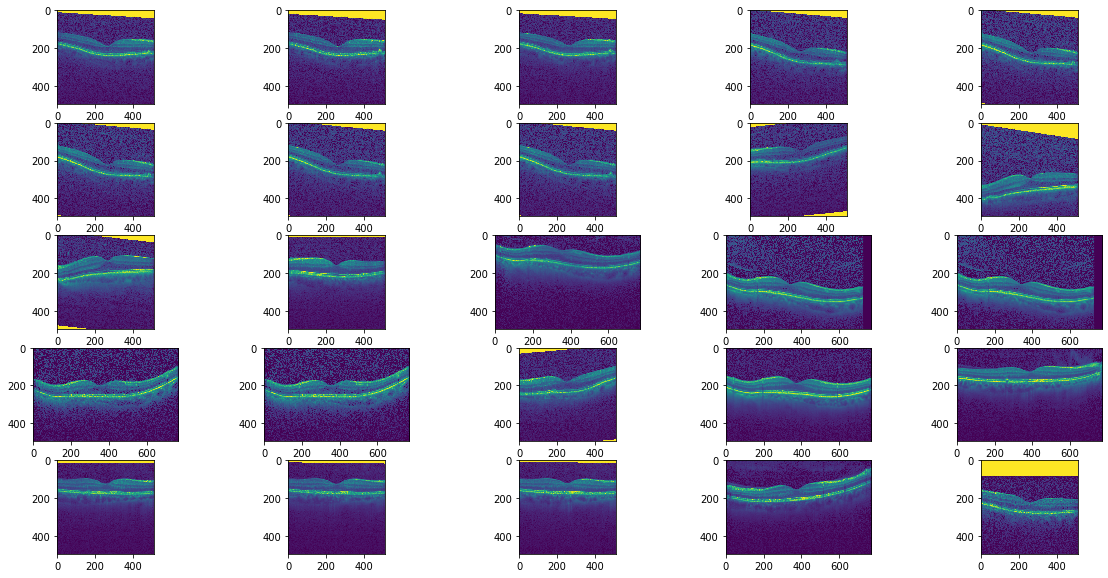

In [7]:
imagesTrainDRUSEN = []
for img_path in glob.glob('../Downloads/kermany2018/OCT2017_/train/DRUSEN/*.jpeg'):
    imagesTrainDRUSEN.append(mpimg.imread(img_path))
plt.figure(figsize=(20,10))
for i in range(0, 25):
    plt.subplot(5, 5, i + 1)
    plt.imshow(imagesTrainDRUSEN[i])

We can see that images are not well aligned and sometimes not even the same size. Thus, we have to ensure that the images are a fixed size and are filtered before we can analyze them any further.

Let's use the image data generator method in keras to preprocess and add images from all of our folders to the respective datasets. [Here is a handy tutorial if you need a primer.](https://medium.com/datadriveninvestor/keras-imagedatagenerator-methods-an-easy-guide-550ecd3c0a92)

In [8]:
from keras.preprocessing.image import ImageDataGenerator
def model_trainer(model):
    train_datagen = ImageDataGenerator(rescale = 1./150, 
                                   shear_range = 0.01, 
                                   zoom_range =[0.9, 1.25],
                                   rotation_range=20,
                                   zca_whitening=True,
                                   vertical_flip=True,
                                   fill_mode='nearest',
                                   width_shift_range=0.1,
                                   height_shift_range=0.1,
                                   brightness_range=[0.5, 1.5],
                                   horizontal_flip = True,
                                   featurewise_center=True, 
                                   featurewise_std_normalization=True)
    test_datagen = ImageDataGenerator(rescale = 1./150)

    train_generator = train_datagen.flow_from_directory(
        TRAIN_PATH,
        target_size=(256,256),
        batch_size=32,
        class_mode='categorical')

    validation_generator = test_datagen.flow_from_directory(
        TEST_PATH,
        target_size=(256,256),
        batch_size=32,
        class_mode='categorical') # multiclass then  categorical

    hist=model.fit_generator(
        train_generator,
        steps_per_epoch=2000, # no of images in training set
        epochs=10,
        shuffle=True,
        validation_data=validation_generator,
        validation_steps=968,callbacks=[early_stop]) # no of  images in test
    return hist,train_generator

Using TensorFlow backend.


Now that we have all of our images in the format that we want, we can start building the models.

In [9]:
# let's import all the dependencies for the modeling first.

from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.feature_extraction.text import TfidfVectorizer
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential, Model, load_model
from keras.layers import Dense, Input, LSTM, Embedding, Dropout, Activation, Conv1D, GRU, CuDNNGRU, CuDNNLSTM, BatchNormalization
from keras.layers import Bidirectional, GlobalMaxPool1D, MaxPooling1D, Add, Flatten, Masking, MaxPooling2D, Convolution2D
from keras.layers import GlobalAveragePooling1D, GlobalMaxPooling1D, concatenate, SpatialDropout1D
from keras import initializers, regularizers, constraints, optimizers, layers, callbacks
from keras import backend as K
from keras.engine import InputSpec, Layer
from keras.optimizers import Adam
from keras.callbacks import ModelCheckpoint,  Callback, EarlyStopping, ReduceLROnPlateau

### Now that we have all of our necessary dependencies for building a model, let's start with a simple 4-layered convolution model that takes our inputs from earlier and returns a fully connected layer with softmax activation.

In [10]:
#  Let's build a model with 4 convolutional layers

def create_model(in_shape,pool_size,kernal_size):
    inputs=Input(shape=in_shape)
    x=Convolution2D(filters=32,kernel_size=kernal_size,activation='relu')(inputs)
    x=MaxPooling2D(pool_size=pool_size)(x)
    x=Dropout(0.3)(x)
    x=Convolution2D(filters=64,kernel_size=kernal_size,activation='relu')(x)
    x=MaxPooling2D(pool_size=pool_size)(x)
    x=Dropout(0.3)(x)
    x=Convolution2D(filters=128,kernel_size=kernal_size,activation='relu')(x)
    x=MaxPooling2D(pool_size=pool_size)(x)
    x=Dropout(0.3)(x)
    x=Convolution2D(filters=128,kernel_size=kernal_size,activation='relu')(x)
    x=MaxPooling2D(pool_size=pool_size)(x)
    x=Dropout(0.3)(x)
    x=Flatten()(x)
    x=Dense(4,activation='softmax')(x)
    return x,inputs

In [11]:
# Let's fix our outputs and input sizes
out,ins=create_model(in_shape=(256,256,3),pool_size=(2,2),kernal_size=(3,3))

**Creating model**

In [12]:
# let's add our inputs and outputs to the model
model=Model(inputs=ins,outputs=out)

In [13]:
model.compile(optimizer='adam',loss='categorical_crossentropy',metrics=['accuracy'])

__Let's create an early stopping callback that stops the model early if it meets the specified critieria.__

In [14]:
from keras.callbacks import EarlyStopping
early_stop=EarlyStopping(monitor='val_loss', min_delta=0, patience=5, verbose=0, mode='auto', baseline=None, restore_best_weights=False)


In [57]:
# You can disable the below line and run your code if you want to avoid seeing all the warnings in your console. I prefer not to see them for any models that are being tested for the first time.
import warnings
warnings.filterwarnings("ignore")

# Running the model

Now that we have everything set and ready, let's call on our model and see how well it's doing.

In [17]:
# Use this code if you would like to configure your gpu fraction (to assign the amount of gpu dedicated for this task.)
# config = tf.compat.v1.ConfigProto
# config.gpu_options.per_process_gpu_memory_fraction = 0.9
# keras.backend.tensorflow_backend.set_session(tf.Session(config=config))

AttributeError: 'google.protobuf.pyext._message.FieldProperty' object has no attribute 'per_process_gpu_memory_fraction'

In [18]:
hist,train_generator=model_trainer(model)
print(hist)

Found 83484 images belonging to 4 classes.
Found 968 images belonging to 4 classes.
Epoch 1/10
2000/2000 [==============================] - 2095s 1s/step - loss: 0.9586 - accuracy: 0.6179 - val_loss: 0.8282 - val_accuracy: 0.5900
Epoch 2/10
2000/2000 [==============================] - 2132s 1s/step - loss: 0.7032 - accuracy: 0.7399 - val_loss: 0.7901 - val_accuracy: 0.5989
Epoch 3/10
2000/2000 [==============================] - 2128s 1s/step - loss: 0.6096 - accuracy: 0.7799 - val_loss: 0.5056 - val_accuracy: 0.8219
Epoch 4/10
2000/2000 [==============================] - 1967s 984ms/step - loss: 0.5116 - accuracy: 0.8165 - val_loss: 0.3926 - val_accuracy: 0.8873
Epoch 5/10
2000/2000 [==============================] - 1936s 968ms/step - loss: 0.4470 - accuracy: 0.8431 - val_loss: 0.4174 - val_accuracy: 0.8687
Epoch 6/10
2000/2000 [==============================] - 1930s 965ms/step - loss: 0.4114 - accuracy: 0.8565 - val_loss: 0.5762 - val_accuracy: 0.9144
Epoch 7/10
2000/2000 [=========

**Taking a sample image. The very first image in test folder under DME class.**

In [19]:
#VISUAL ANALYSIS    
from keras.preprocessing import image    
im1_path="../Downloads/kermany2018/OCT2017_/test/NORMAL/NORMAL-1025847-1.jpeg"
test_image=image.load_img(im1_path,target_size=(256,256))

196608


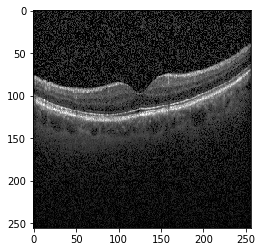

In [20]:
plt.imshow(test_image)
# Let's convert our image from a 2d image to a 3d image.
# But first, we have to convert our image to an array
test_image=image.img_to_array(test_image)
print(test_image.size)


In [21]:
# Once we convert our image to an array, we can expand dimensions using the following code
test_image= np.expand_dims(test_image,axis=0)


In [22]:
# We have 4 classes in our data. Let's get the indices for them.
train_generator.class_indices

{'CNV': 0, 'DME': 1, 'DRUSEN': 2, 'NORMAL': 3}

In [23]:
# Now, let's see how well our predictive model is doing on our test_image. Remember that we grabbed this image from our "NORMAL" folder, so we should see 3 as our output.
result=np.argmax(model.predict(test_image))
print(result)

3


GREAT! Our model was able to identify the normal image as a normal image! Given that our model's accuracy is around 90%, we should expect good results for most test cases. But we do not yet know how well our model is doing on our test dataset. Let's work on our model to get this information.

**Before we get the final predictions on our test dataset, let's take a look at the intermediary steps of our model. This will allow us to see what is going on within our convolutional layers and how the filerting is changing our images.**

In [25]:
# Let's write a function that looks at our filters and biases and append them to their respective lists.
def get_name_layer_filters(model):
    filter_whole=[]
    layer_whole=[]
    for layer in model.layers:
        if 'conv' not in layer.name:
            continue
        filters,biases=layer.get_weights()
        filter_whole.append(filters)
        layer_whole.append(biases)
        print(layer.name,filters.shape)
    return filter_whole,layer_whole    
        

**Now Let's use the model we built to output the filters and biases.**

In [26]:
filter_whole,layer_whole=get_name_layer_filters(model)

conv2d_1 (3, 3, 3, 32)
conv2d_2 (3, 3, 32, 64)
conv2d_3 (3, 3, 64, 128)
conv2d_4 (3, 3, 128, 128)


**Now let's focus on our layer 1 and get the weights assigned to this layer.**

In [27]:
# Getting filters and biases from layer1
filters,biases=model.layers[1].get_weights()

**Normalizing the filters**

In [28]:
# and then normalizing our filters with a minmax approach
f_min,f_max=filters.min(),filters.max()
filters=(filters-f_min)/(f_max-f_min)

**Plotting the filters**

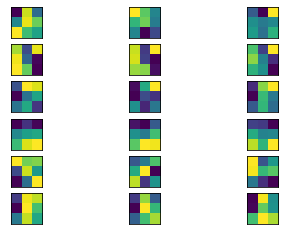

In [29]:
# Let's inspect our filters visually!
from matplotlib import pyplot
n_filters,ix=6,1
for i in range(n_filters):
    f=filters[:,:,:,i]
    #Plot each channel
    for j in range(3):
        ax=pyplot.subplot(n_filters,3,ix)
        ax.set_xticks([])
        ax.set_yticks([])
        #Plot filter channel
        pyplot.imshow(f[:,:,j])
        ix+=1
        
pyplot.show()    

**Starting with the plotting**

**Making a model from feature map.We will start with making a model with outputs from 1st convolution layer of model and input from model.**


In [30]:
#FEATURE MAP
model_feature=Model(inputs=model.inputs,outputs=model.layers[4].output)

**Using previous model to predict test_image**

In [31]:
#We use result from previous
feature_map=model_feature.predict(test_image)


In [32]:
feature_map.shape

(1, 125, 125, 64)

**Plot feature maps**

32 feature maps will be plotted. We will try to analyze these maps and interpret them in a useful way after plotting them.

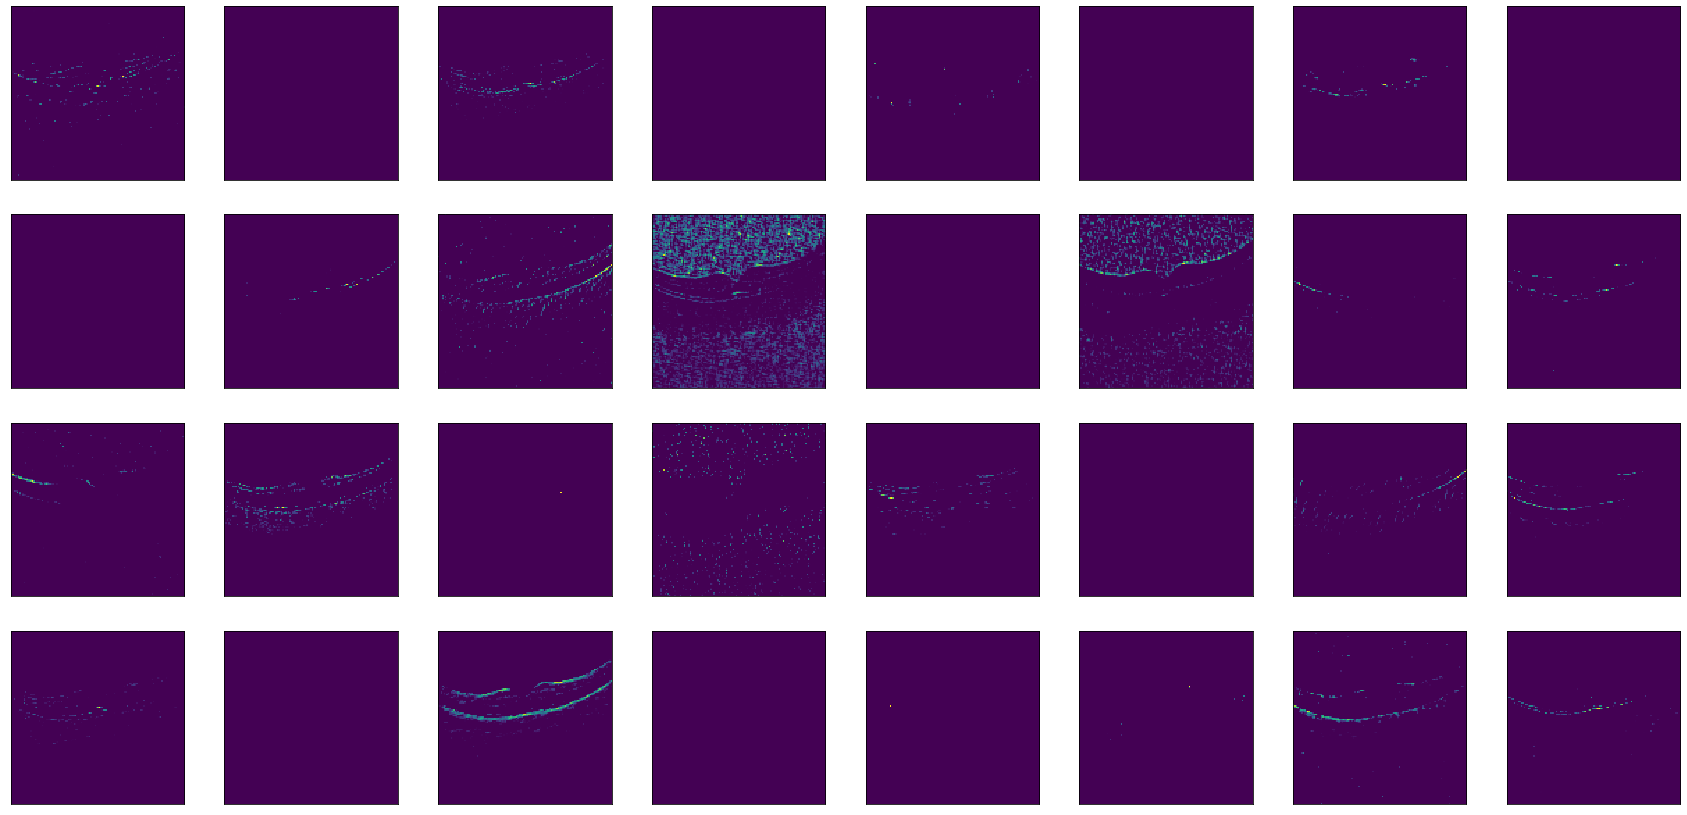

In [33]:
#plot all 32 maps in an 8*4 squares
pyplot.figure(figsize=(30,30))        
        
square=8
ix=1
for _ in range(4):
    for _ in range(8):
        ax=pyplot.subplot(square,square,ix)
        ax.set_xticks([])
        ax.set_yticks([])
        pyplot.imshow(feature_map[0,:,:,ix-1])
        ix+=1
        
pyplot.show()

**We can well observe that our model in its first convolutional layer is trying to detect features as evident from feature maps above.We can even observe edge detections as observed in the subplot(2,5).The model tries to detect the image and is studying its features. Some of these features can be easily seen by human eye. Higher the convoluional layers finer these detections become as becomes evident when we further plot next convolutional layers.**


**Now implementing above feature map plotting for all convolution layer.**

**This function returns models from all convolutional layers in our model**

In [34]:
def get_convolutional_layers(model):
    convolutions_models=[]
    for layer in model.layers:
        if 'conv2d' not in layer.name:
            continue
        model_temp=Model(inputs=model.inputs,outputs=layer.output)
        convolutions_models.append(model_temp)
    return convolutions_models    
        
        

**This function returns feature maps and models list**

In [35]:
#To see each feature map systematically for every convolutional layer
def generate_feature_maps(model,test_image):
    models=get_convolutional_layers(model)#Fetching convolution layers models
    feature_maps=[]
    
    for model_temp in models:
        feature_map=model_feature.predict(test_image)
        feature_maps.append(feature_map)
    return feature_maps,models    


**This function plots 32 feature maps.**

In [36]:
def plot_graph(feature_map):
    
    #plot all 32 maps in an 8*4 squares
    pyplot.figure(figsize=(30,30))        
        
    square=8
    ix=1
    for _ in range(4):
        for _ in range(8):
            ax=pyplot.subplot(square,square,ix)
            ax.set_xticks([])
            ax.set_yticks([])
            pyplot.imshow(feature_map[0,:,:,ix-1])
            ix+=1
        
    pyplot.show()

**Generating plots and showing original image.**

In [37]:
def plots_generator(model):
    print("IMAGE UNDER CONSIDERATION")
    test_image=image.load_img(im1_path,target_size=(256,256))
    plt.imshow(test_image)
    test_image=image.img_to_array(test_image)

    test_image= np.expand_dims(test_image,axis=0)
    print()
    feature_maps,models=generate_feature_maps(model,test_image)
    #ax=pyplot.subplot(square,square,ix)# only 32 filters will be shown of each layer
    counter=1
    for each_map in feature_maps:
        print("Convolutional Layer Number {} ".format(counter))
        counter+=1
        #ax=pyplot.subplot(square,square,ix)
        plot_graph(each_map)


**Function to start with plotting feature maps.**

IMAGE UNDER CONSIDERATION

Convolutional Layer Number 1 


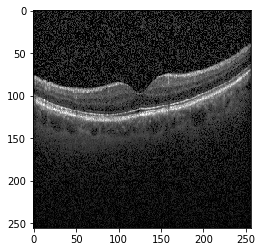

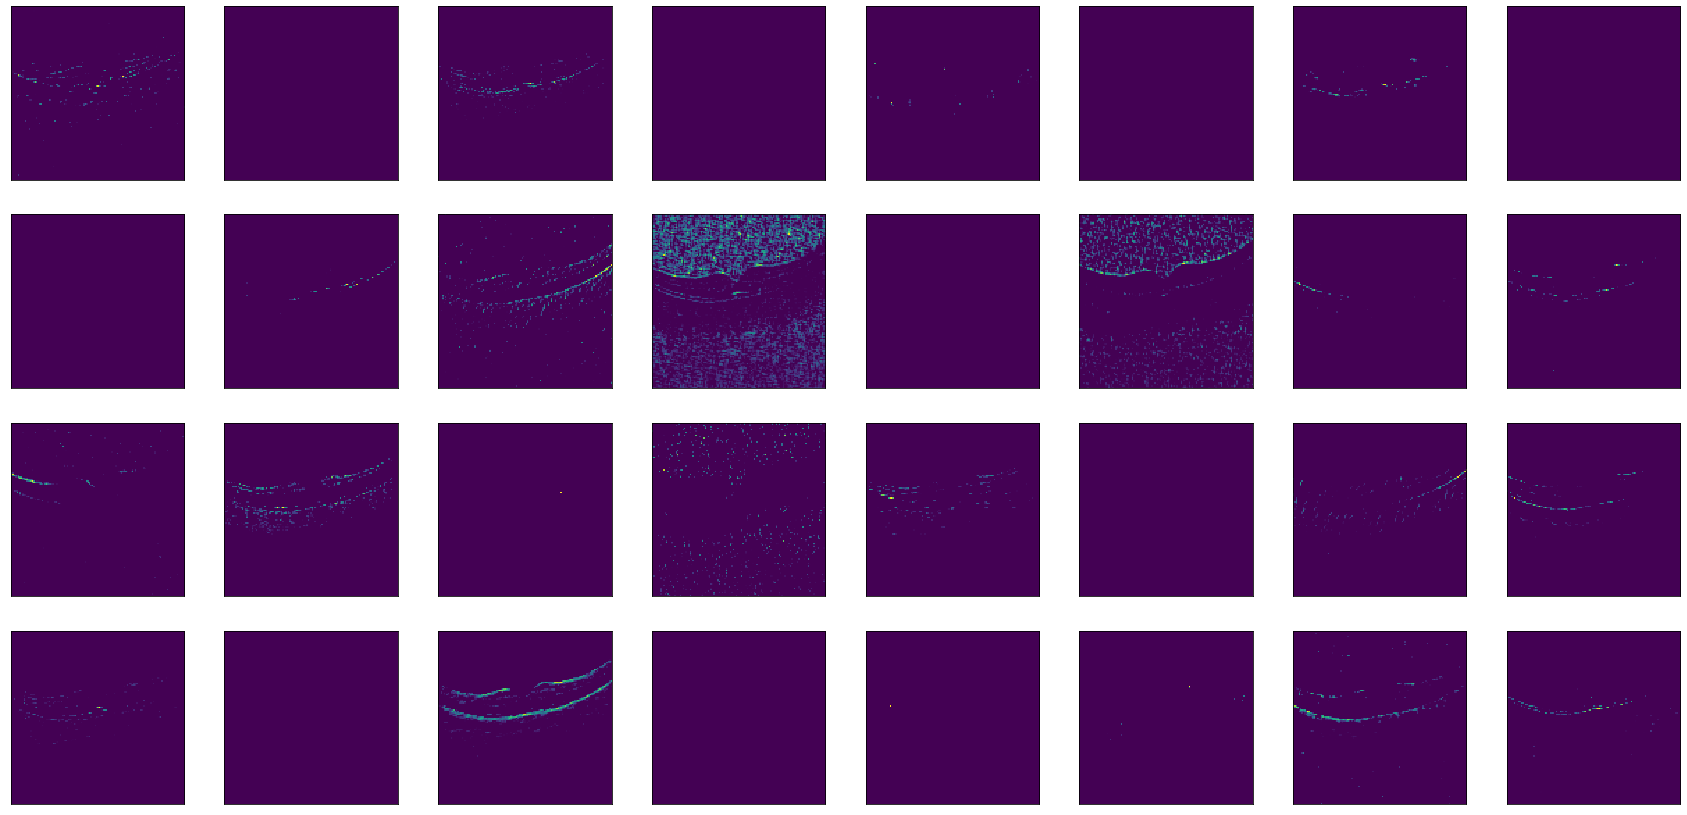

Convolutional Layer Number 2 


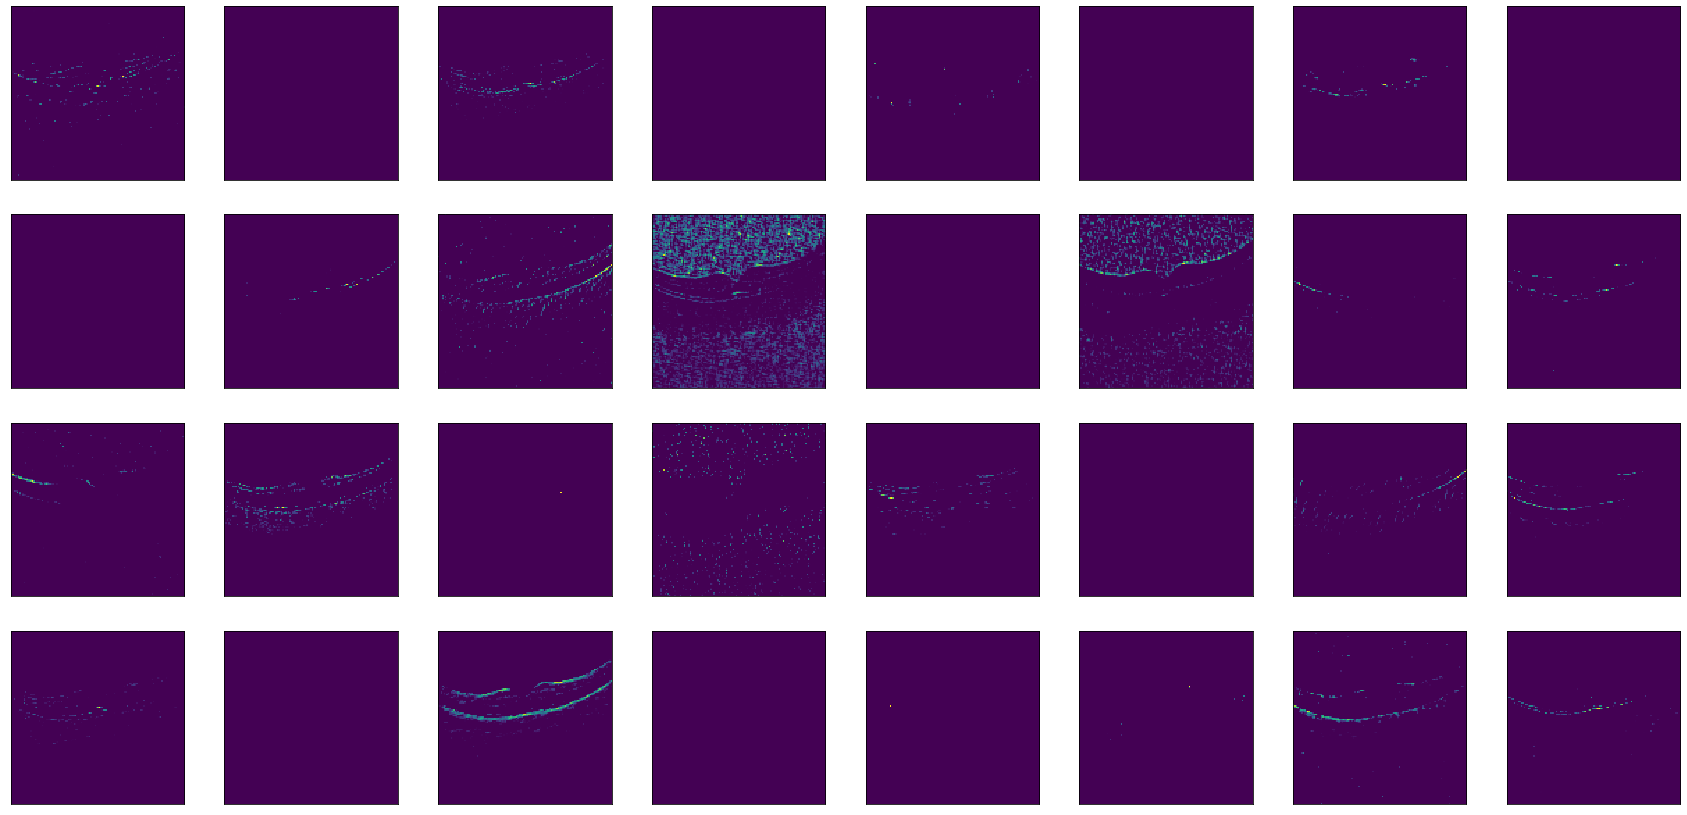

Convolutional Layer Number 3 


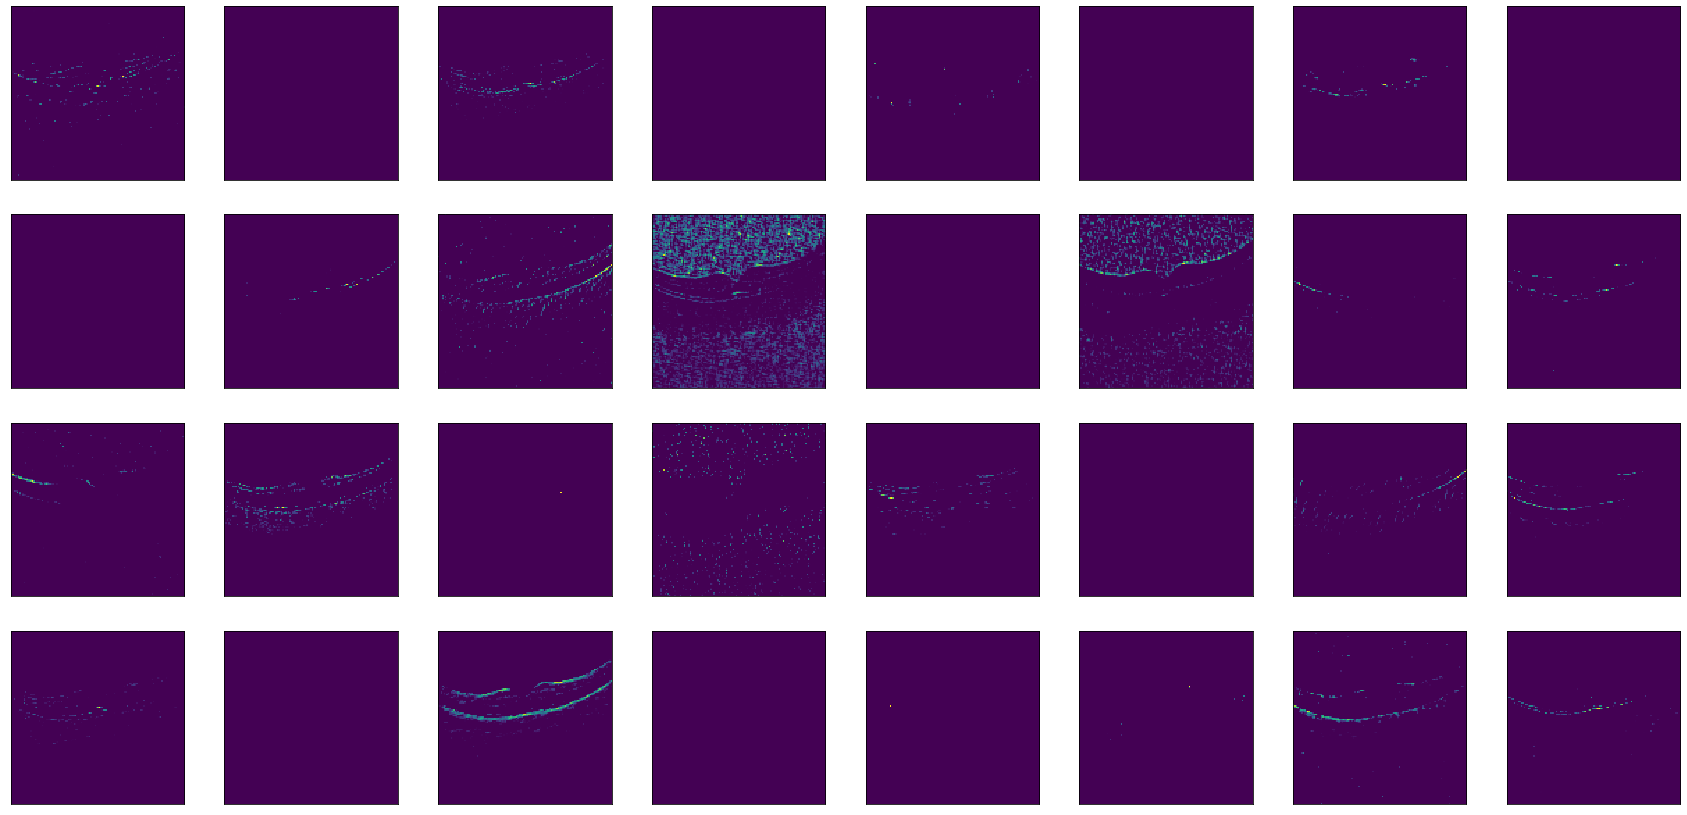

Convolutional Layer Number 4 


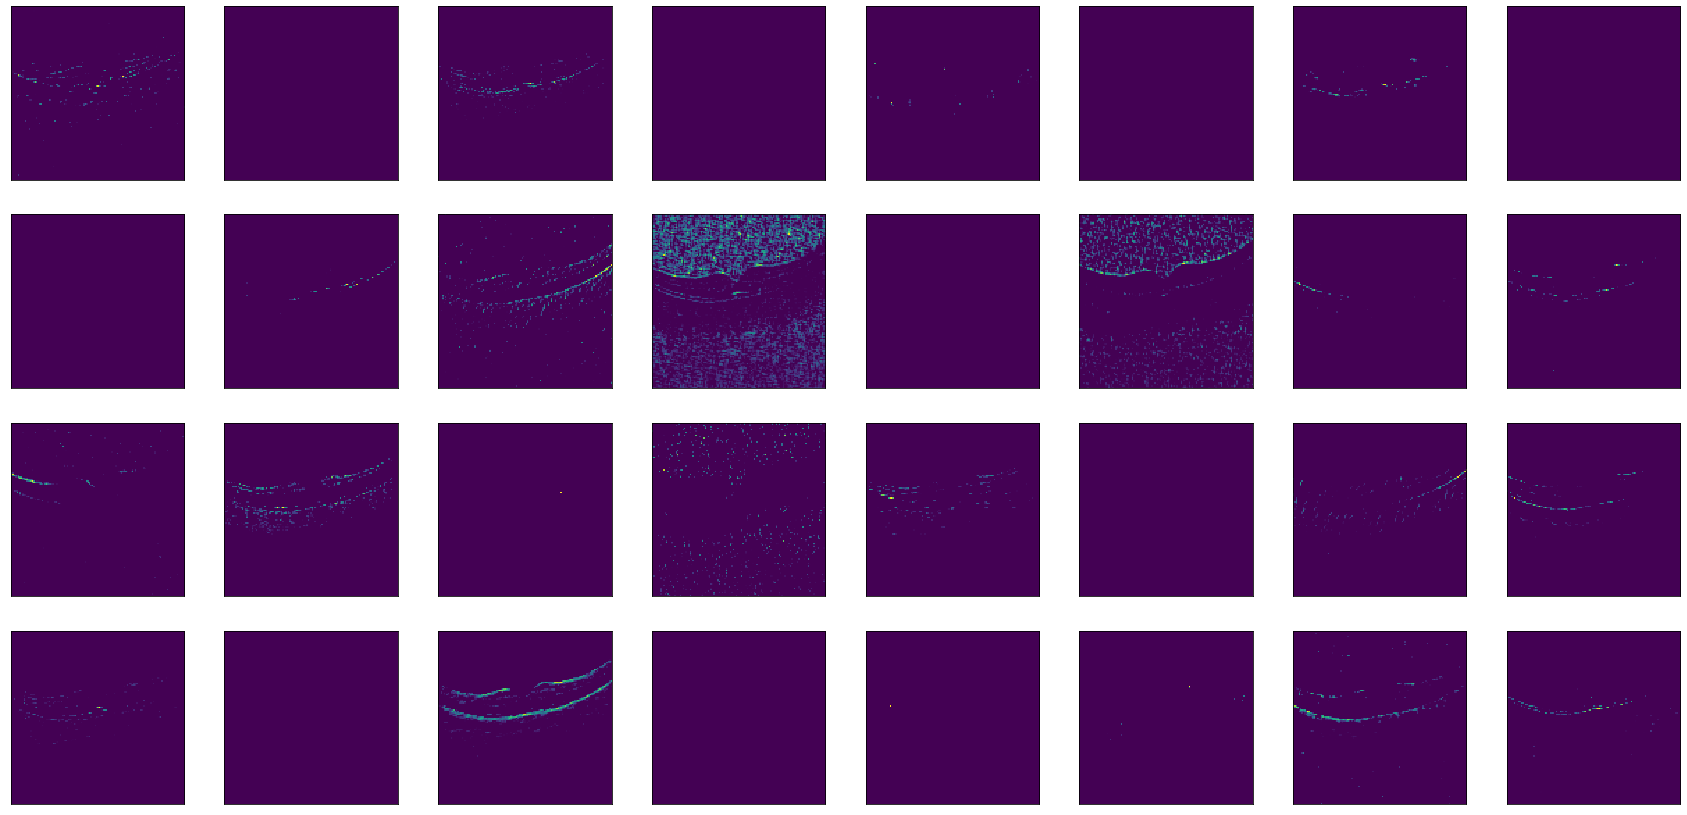

In [38]:

plots_generator(model)

**Now as we can observe as we move into deeper convolutional layers features get more refined and clearer. We can also add up custom filters which may lead to better feature detection, however let's keep it for our next kernel.**

In [40]:
hist.history['val_accuracy']

[0.5899708867073059,
 0.598868727684021,
 0.8218774795532227,
 0.8872717618942261,
 0.8687102794647217,
 0.9143622517585754,
 0.9310333132743835,
 0.9183646440505981,
 0.9328323602676392,
 0.9274278879165649]

**Checking Validation accuracies**

In [46]:
def val_acc_plot():
    print("FOR MODEL VALIDATION DATA")
    plt.plot(hist.epoch,hist.history['val_accuracy'])
    plt.xlabel("EPOCHS")
    plt.ylabel("Validation Accuracy")
    

In [53]:
def generate_images(all_paths):
    test_images=[]
    interpret=train_generator.class_indices
    test_y=[]
    
    for path in all_paths:
        y=''
        if 'DME' in path:
            y='DME'
        elif 'DRUSEN' in path:   
            y='DRUSEN'
        elif 'CNV' in path:   
            y='CNV'
        elif 'NORMAL' in path:   
            y='NORMAL'    
        
        for image_path in os.listdir(path):
            new_path=os.path.join('../Downloads/kermany2018/OCT2017_/test',y)
            #print(new_path)
            
            new_path=os.path.join(new_path,image_path)
            if 'Store' in str(new_path):
                continue
            temp_images=image.load_img(new_path,target_size=(256,256))
            temp_images=image.img_to_array(temp_images)
            test_images.append(temp_images)
            test_y.append(interpret[y])
    return test_images,test_y        


In [54]:
def generate_predictions(test_images,model):
    predictions=np.argmax(model.predict(test_images),axis=1)
    return predictions
    

In [55]:
from sklearn import metrics

def convert_data(model):
    # Now testing all test images to find test set accuracy.
    #We first need to put all test images and convert them in desired format to predict
    #Firstly we store path of test directory
    PATH_TEST=r"../Downloads/kermany2018/OCT2017_/test"
    all_paths=[]
    print("GENERATING PATHS")
    for directory in os.listdir(PATH_TEST):
        if 'Store' in directory:
            continue
        all_paths.append(os.path.join(PATH_TEST,directory))
    
    test_images,test_y=generate_images(all_paths)
    print("PATH GENERATED")
    test_images=np.array(test_images)
    print("GENERATING PREDICTIONS")
    predictions=generate_predictions(test_images,model)
    print("PREDICTIONS GENERATED")
    print()
    print("ACCURACY OF MODEL FOR TEST DATA IS {}".format(metrics.accuracy_score(test_y, predictions)))
    
    


In [56]:
convert_data(model)

GENERATING PATHS
PATH GENERATED
GENERATING PREDICTIONS
PREDICTIONS GENERATED

ACCURACY OF MODEL FOR TEST DATA IS 0.84400826446281


In [58]:
# Let's save this model so we can refine it later!

# serialize model to JSON
model_json = model.to_json()
with open("modelRetOCT.json", "w") as json_file:
    json_file.write(model_json)
# serialize weights to HDF5
model.save_weights("modelRetOCT.h5")
print("Saved model to disk")
 

Saved model to disk


In [59]:
'''
# later... when we need to use our model we can run the following code
 
# load json and create model
json_file = open('modelRetOCT.json', 'r')
loaded_model_json = json_file.read()
json_file.close()
loaded_model = model_from_json(loaded_model_json)
# load weights into new model
loaded_model.load_weights("modelRetOCT.h5")
print("Loaded model from disk")
 
# evaluate loaded model on test data
loaded_model.compile(loss='binary_crossentropy', optimizer='rmsprop', metrics=['accuracy'])
score = loaded_model.evaluate(X, Y, verbose=0)
print("%s: %.2f%%" % (loaded_model.metrics_names[1], score[1]*100))

'''

'\n# later... when we need to use our model we can run the following code\n \n# load json and create model\njson_file = open(\'modelRetOCT.json\', \'r\')\nloaded_model_json = json_file.read()\njson_file.close()\nloaded_model = model_from_json(loaded_model_json)\n# load weights into new model\nloaded_model.load_weights("modelRetOCT.h5")\nprint("Loaded model from disk")\n \n# evaluate loaded model on test data\nloaded_model.compile(loss=\'binary_crossentropy\', optimizer=\'rmsprop\', metrics=[\'accuracy\'])\nscore = loaded_model.evaluate(X, Y, verbose=0)\nprint("%s: %.2f%%" % (loaded_model.metrics_names[1], score[1]*100))\n\n'

In [60]:
model.save("modelRetinalOCT.h5")
print("Saved model to disk")

Saved model to disk


In [ ]:
'''
from numpy import loadtxt
from keras.models import load_model
 
# load model
model = load_model('modelRetinalOCT.h5')
# summarize model.
model.summary()
# load dataset
dataset = loadtxt("pima-indians-diabetes.csv", delimiter=",")
# split into input (X) and output (Y) variables
X = dataset[:,0:8]
Y = dataset[:,8]
# evaluate the model
score = model.evaluate(X, Y, verbose=0)
print("%s: %.2f%%" % (model.metrics_names[1], score[1]*100))
'''